In [6]:
%load_ext autoreload
%autoreload 2
# from mulitmodel import *
# from psi4_ import *
# from multipoles import plot_moments, calc_esp_from_multipoles
from rdkit import Chem
from rdkit.Chem import AllChem
import jax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
RANDOM_NUMBER = 0
filename = "test"
data_key, train_key = jax.random.split(jax.random.PRNGKey(RANDOM_NUMBER), 2)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Create Molecule

In [8]:
smiles = 'C1=C(NC=N1)CC(C(=O)O)N'
# smiles = 'CC(CC1=CC=CC=C1)NC'

smiles_mol = Chem.MolFromSmiles(smiles)
rdkit_mol = Chem.AddHs(smiles_mol) 
elements = [a.GetSymbol() for a in rdkit_mol.GetAtoms()]
# Generate a conformation
AllChem.EmbedMolecule(rdkit_mol)
coordinates = rdkit_mol.GetConformer(0).GetPositions()
surface = get_grid_points(coordinates)

NameError: name 'get_grid_points' is not defined

In [4]:
surface.shape

(2564, 3)

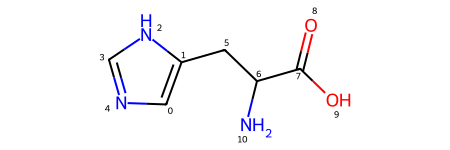

In [5]:
for i, atom in enumerate(smiles_mol.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("atomNote", str(atom.GetIdx()))
# display molecule
smiles_mol

In [164]:
# for i, atom in enumerate(rdkit_mol.GetAtoms()):
#     # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
#     atom.SetProp("atomNote", str(atom.GetIdx()))
# rdkit_mol

# Generate ESP from DFT

In [ ]:
make_psi4_dir(Path(filename))
surface = get_grid_points(coordinates)
esp_calc(surface, coordinates, elements)

test


#  Load data

In [182]:
outdata = np.load(Path("/home/boittier/jaxeq/psi4") / "test" / "multipoles.npz")
elements = outdata["elements"]

coordinates = outdata["monomer_coords"] 
monopoles = outdata["monopoles"]
esp = np.fromfile(Path("/home/boittier/jaxeq/psi4") / "test" /  "grid_esp.dat", sep=" ")
grid = outdata["surface_points"] 
vdw_surface = grid 
max_N_atoms = 60
max_grid_points = 3143
max_grid_points - len(vdw_surface)
Z = [np.array([ase.data.atomic_numbers[_.capitalize()] for _ in elements])]
pad_Z = np.array([np.pad(Z[0], ((0,max_N_atoms - len(Z[0]))))])
pad_coords = np.array([np.pad(coordinates, ((0, max_N_atoms - len(coordinates)), (0,0)))])

pad_mono = np.array([np.pad(monopoles,((0,max_N_atoms - len(monopoles)), (0,0)))])
pad_esp =  [np.pad(esp,((0,max_grid_points - len(esp))))]
pad_esp = np.array(pad_esp)
pad_vdw_surface = []
_ = np.pad(vdw_surface, ((0, max_grid_points - len(vdw_surface)), (0,0)), "constant", constant_values=(0, 10000)) 
pad_vdw_surface.append(_)
pad_vdw_surface = np.array(pad_vdw_surface)

data_batch = dict(
    atomic_numbers=jnp.asarray(pad_Z),
    positions=jnp.asarray(pad_coords),
    mono=jnp.asarray(pad_mono),
    ngrid=jnp.array([len(vdw_surface)]),
    esp=jnp.asarray(pad_esp),
    vdw_surface=jnp.asarray(pad_vdw_surface),
)

psi4_test_batches = prepare_batches(data_key, data_batch, batch_size)

batchID = 0
errors_train = []
batch = psi4_test_batches[batchID]

In [183]:
# outdata["quadrupoles"].shape
# print(outdata["quadrupoles"].shape)
# print(outdata["quadrupoles"])

In [184]:
from jax import vmap

def make_traceless(Q):
    trace_Q = jnp.trace(Q, axis1=0, axis2=1)  # Correct axis for trace
    correction = trace_Q / 3
    Q_traceless = Q - jnp.expand_dims(jnp.eye(3) * correction, axis=0)  # Correct shape broadcasting
    return Q_traceless.squeeze()

# Vectorized over each matrix in the 60 matrices group
vectorized_over_matrices = vmap(make_traceless, in_axes=(0), out_axes=(0))


outdata = {"monopoles": outdata["monopoles"],
           "dipoles": outdata["dipoles"],
           "quadrupoles": np.asarray(vectorized_over_matrices( outdata["quadrupoles"])), 
           "elements": outdata["elements"],
           "xyz": coordinates,
           "esp": esp,
           "grid": grid,
          }

In [185]:
grid.shape

(2516, 3)

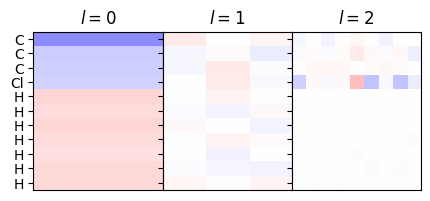

In [186]:
plot_moments(outdata)

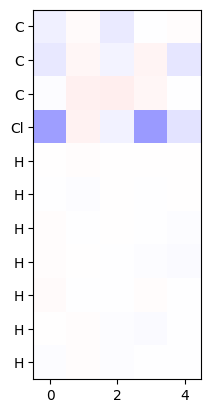

In [187]:
irreps = e3x.so3.irreps.tensor_to_irreps(outdata["quadrupoles"], 2)
plt.imshow(irreps, cmap='bwr', vmin=-1, vmax=1)
_ = plt.gca().set_yticks(range(len(outdata["elements"])), outdata["elements"])

In [188]:
magnitudes_dip = jnp.linalg.norm(outdata["dipoles"], axis=1)
# plt.imshow(magnitudes_dip.reshape(len(magnitudes_dip), 1), cmap='Reds', vmin=0, vmax=1)
# _ = plt.gca().set_yticks(range(len(outdata["elements"])), outdata["elements"])
magnitudes_dip

Array([0.09385306, 0.08962759, 0.09681447, 0.08882166, 0.05197757,
       0.05273774, 0.04972005, 0.05469644, 0.05279661, 0.05556503,
       0.05761426], dtype=float32)

In [189]:
dipoles_ranked = np.argsort(magnitudes_dip)[::-1]
dipoles_ranked

Array([ 2,  0,  1,  3, 10,  9,  7,  8,  5,  4,  6], dtype=int32)

In [231]:
dipoles_ranked_cutoff = dipoles_ranked[magnitudes_dip[dipoles_ranked] > 0.075]
dipoles_ranked_cutoff

Array([2, 0, 1, 3], dtype=int32)

In [232]:
magnitudes = jnp.linalg.norm(irreps, axis=1)
# plt.imshow(magnitudes.reshape(len(magnitudes), 1), cmap='Reds', vmin=0, vmax=1)
# _ = plt.gca().set_yticks(range(len(outdata["elements"])), outdata["elements"])
magnitudes

Array([0.1050573 , 0.14688644, 0.0936672 , 0.56262374, 0.01245955,
       0.01624772, 0.01616913, 0.02526997, 0.0231378 , 0.02591958,
       0.02331137], dtype=float32)

In [233]:
quads_ranked = np.argsort(magnitudes)[::-1]
# quads_ranked

In [234]:
quads_ranked_cutoff = quads_ranked[magnitudes[quads_ranked] > 0.1]
quads_ranked_cutoff

Array([3, 1, 0], dtype=int32)

In [235]:
monopole_esp, dipole_esp, quad_esp = calc_esp_from_multipoles(outdata)

In [236]:
monopole_esp.shape

(2516,)

In [237]:
outdata["grid"].shape

(2516, 3)

2516


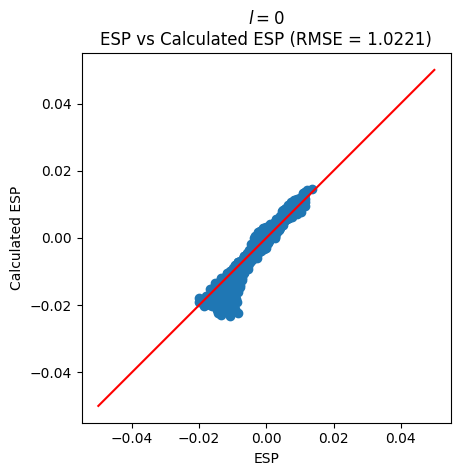

2516


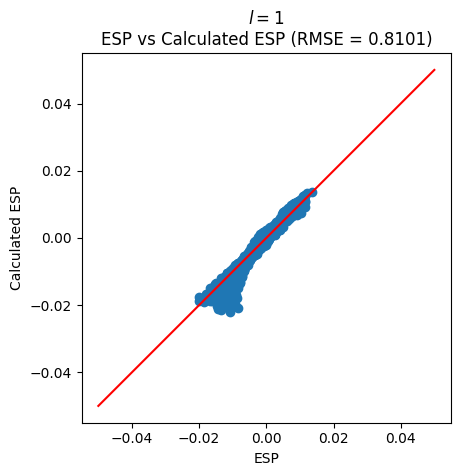

2516


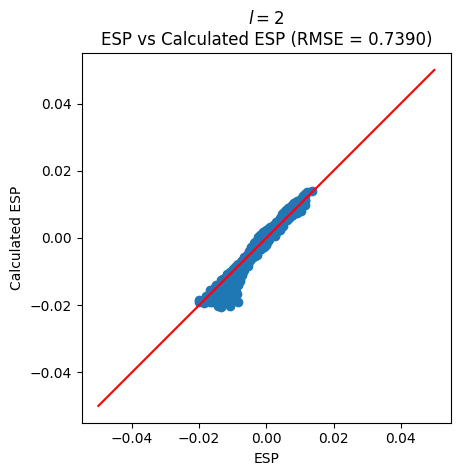

In [238]:
from multipoles import plot_esp as multipoles_plot_esp

multipoles_plot_esp(outdata["esp"], monopole_esp, title="$l=0$")
multipoles_plot_esp(outdata["esp"], monopole_esp + dipole_esp, title="$l=1$")
multipoles_plot_esp(outdata["esp"], monopole_esp + dipole_esp + quad_esp, title="$l=2$")


# Generate predictions

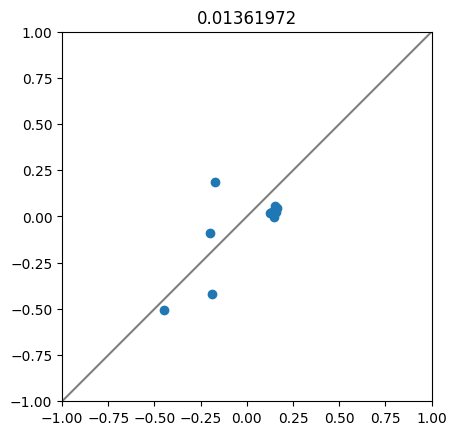

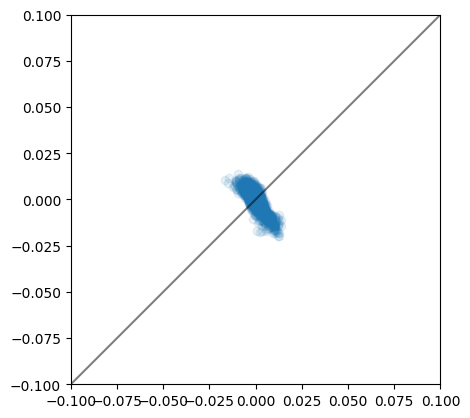

2516 gridpoints


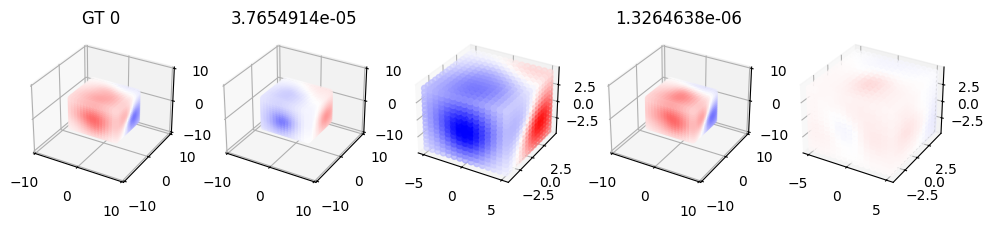

rmse: 4.872196
[   0    1    2 ... 3140 3141 3142]


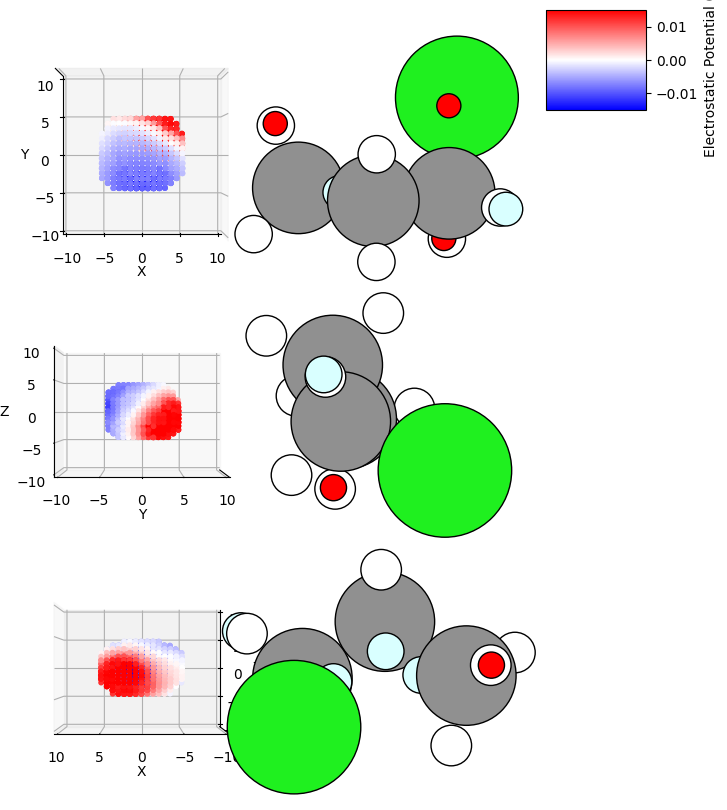

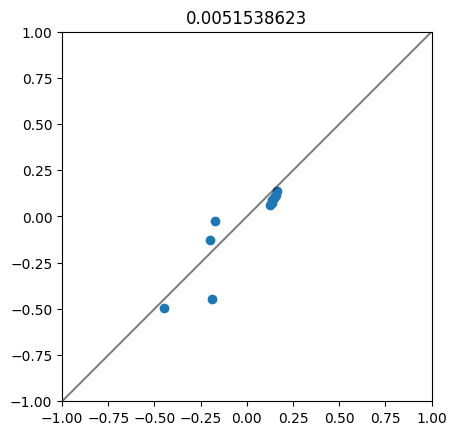

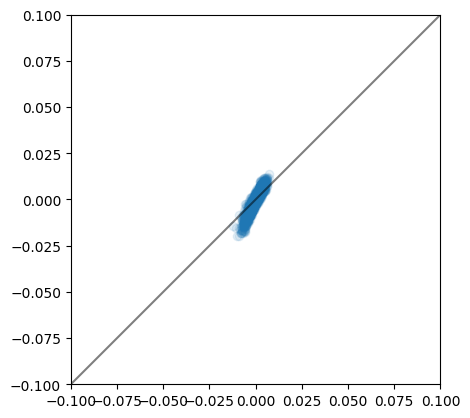

2516 gridpoints


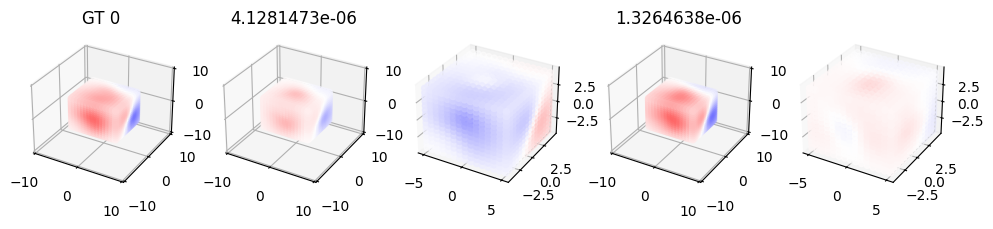

rmse: 1.6132123
[   0    1    2 ... 3140 3141 3142]


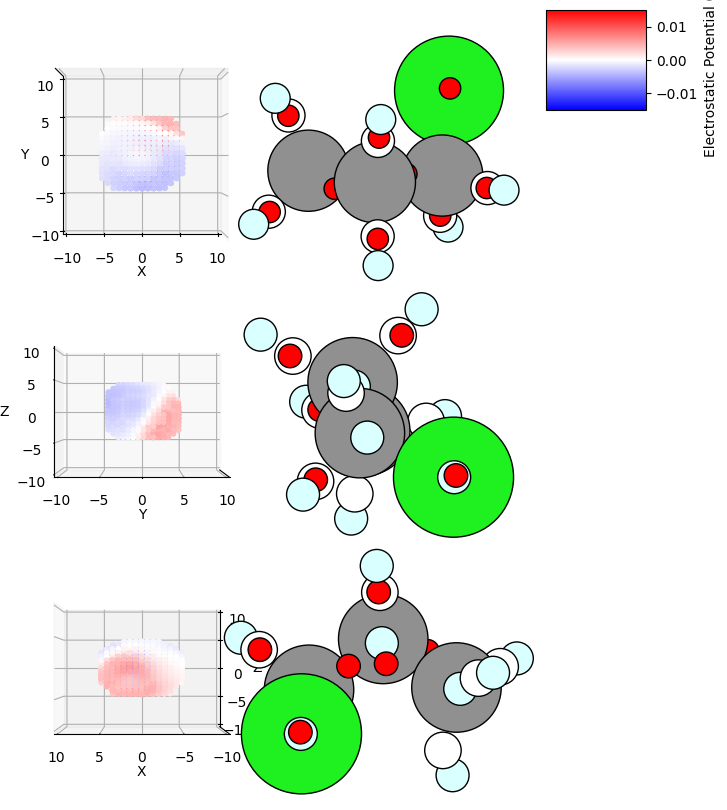

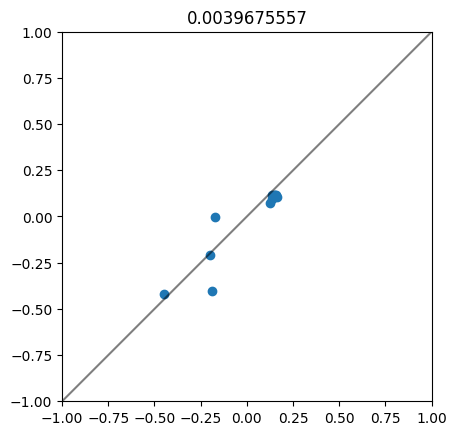

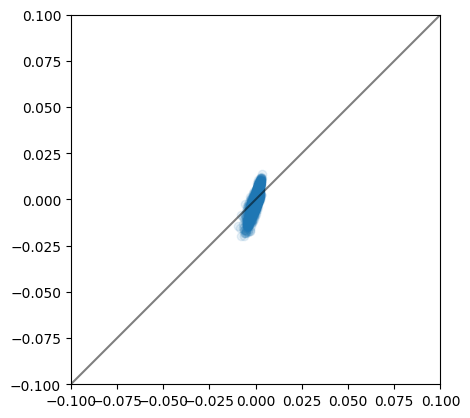

2516 gridpoints


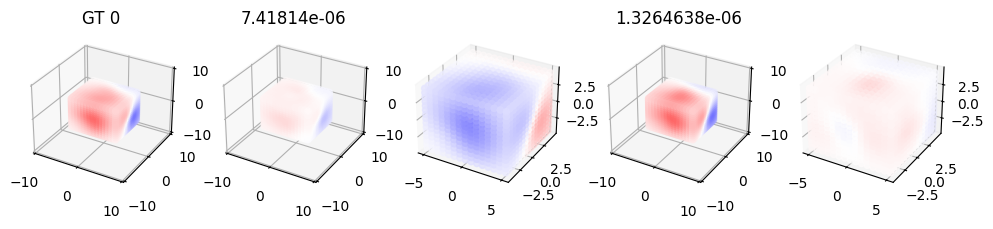

rmse: 2.1625264
[   0    1    2 ... 3140 3141 3142]


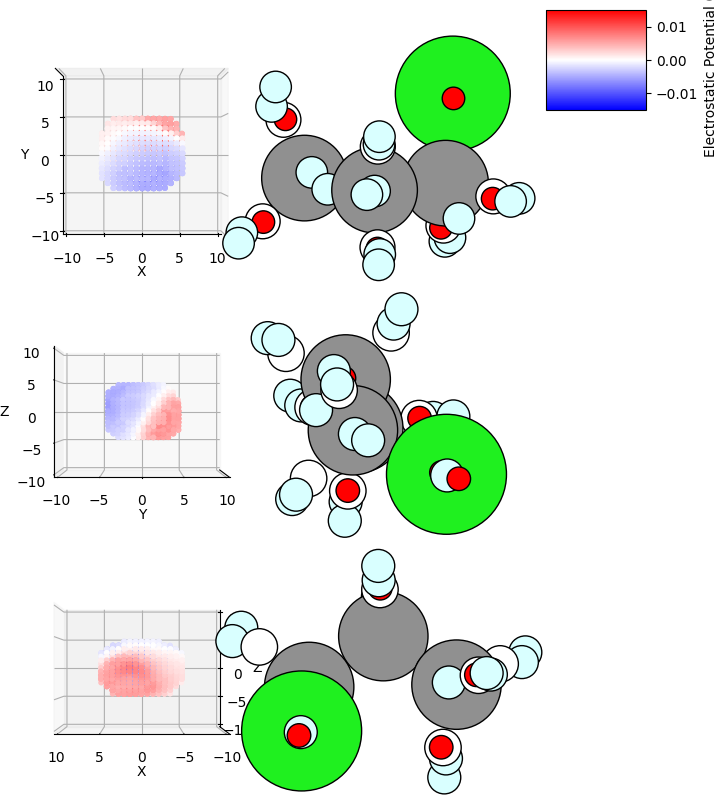

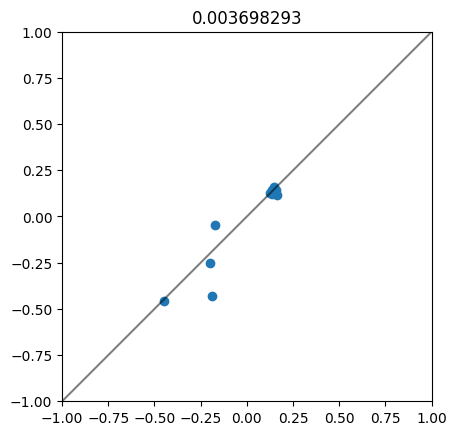

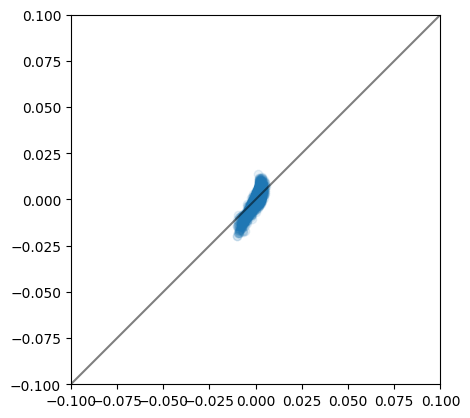

2516 gridpoints


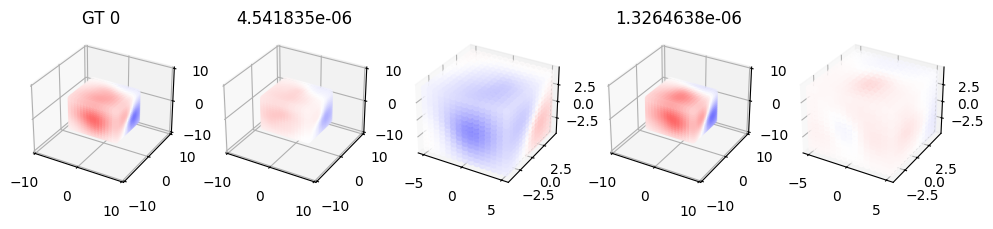

rmse: 1.692114
[   0    1    2 ... 3140 3141 3142]


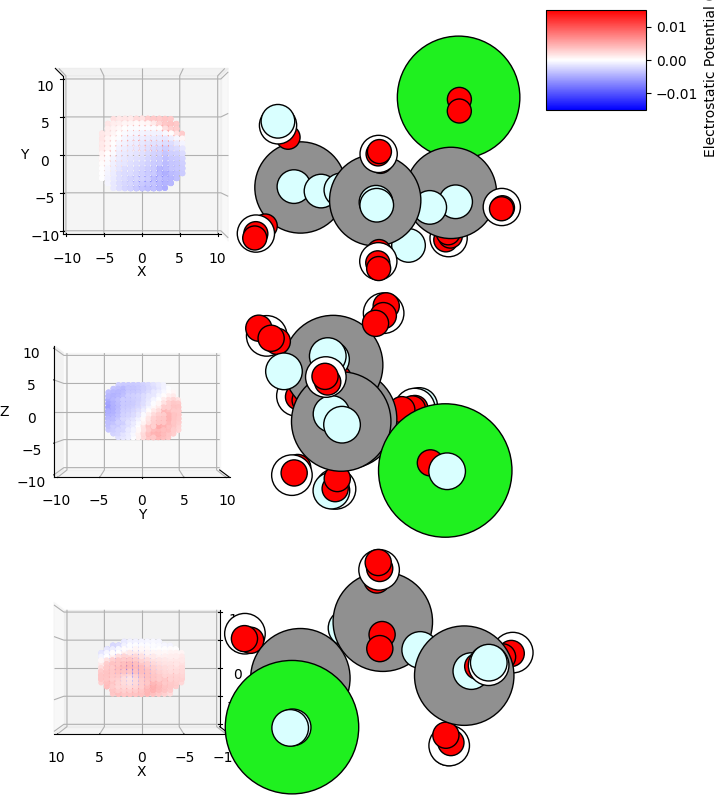

In [239]:
dcm1_results = plot_model(DCM1, dcm1_params, batch, batch_size, 1)
dcm2_results = plot_model(DCM2, dcm2_params, batch, batch_size, 2)
dcm3_results = plot_model(DCM3, dcm3_params, batch, batch_size, 3)
dcm4_results = plot_model(DCM4, dcm4_params, batch, batch_size, 4)

#  View structures

In [240]:
atoms = dcm1_results["atoms"]
dcmol1 = dcm1_results["dcmol"]
dcmol2 = dcm2_results["dcmol"]
dcmol3 = dcm3_results["dcmol"]
dcmol4 = dcm4_results["dcmol"]

# from ase.visualize import view
# view(atoms+dcmol2, viewer="x3d")

In [241]:
batch.keys()

dict_keys(['mono', 'ngrid', 'esp', 'vdw_surface', 'atomic_numbers', 'positions', 'dst_idx', 'src_idx', 'batch_segments'])

In [242]:
dc1, dcq1, atomwise_charge_array1 = make_charge_xyz(
    dcm1_results["mono"], dcm1_results["dipo"], batch, batch_size, 1)
dc2, dcq2, atomwise_charge_array2 = make_charge_xyz(
    dcm2_results["mono"], dcm2_results["dipo"], batch, batch_size, 2)
dc3, dcq3, atomwise_charge_array3 = make_charge_xyz(
    dcm3_results["mono"], dcm3_results["dipo"], batch, batch_size, 3)
dc4, dcq4, atomwise_charge_array4 = make_charge_xyz(
    dcm4_results["mono"], dcm4_results["dipo"], batch, batch_size, 4)

In [243]:
dc1mono, dcq1mono, atomwise_charge_array_mono = make_charge_xyz(
    batch["mono"], batch["positions"], batch, batch_size, 1)

# Combine and Optimize

In [244]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array_mono, #Hs
                              atomwise_charge_array_mono
                              )
get_esp_rmse_from_combined(combined, batch) 

(11, 4)


Array(1.0220649, dtype=float32)

In [245]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(11,) 2442


/home/boittier/jaxeq/mulitmodel.py:977: OptimizeWarning: Unknown solver options: ftol, eps
  res = minimize(self.loss_fn_only_q, x0,


Maximum number of function evaluations has been exceeded.


/home/boittier/jaxeq/mulitmodel.py:977: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(self.loss_fn_only_q, x0,


In [246]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.5800192952156067
             x: [ 9.730e-03  9.776e-02 -9.998e-02  8.086e-02  1.961e-03
                 -5.256e-03 -1.865e-03 -3.657e-04  1.074e-02  3.820e-02
                 -2.948e-03]
           nit: 1685
          nfev: 2442
 final_simplex: (array([[ 9.730e-03,  9.776e-02, ...,  3.820e-02,
                        -2.948e-03],
                       [ 9.841e-03,  9.776e-02, ...,  3.814e-02,
                        -3.024e-03],
                       ...,
                       [ 9.613e-03,  9.773e-02, ...,  3.833e-02,
                        -2.827e-03],
                       [ 9.777e-03,  9.776e-02, ...,  3.816e-02,
                        -2.961e-03]]), array([ 5.800e-01,  5.800e-01,  5.800e-01,  5.800e-01,
                        5.800e-01,  5.800e-01,  5.800e-01,  5.800e-01,
                        5.800e-01,  5.800e-01,  5.800e-01,  5.800e-01])

2516


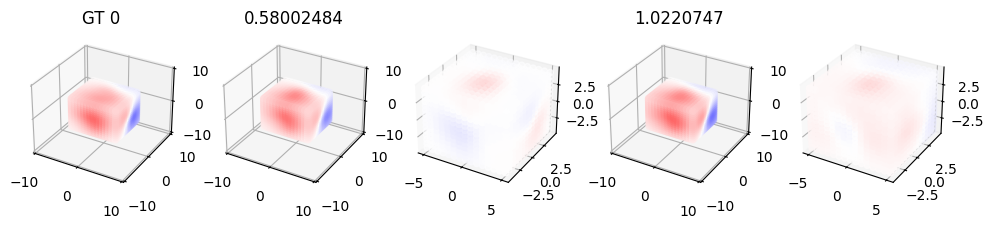

1538


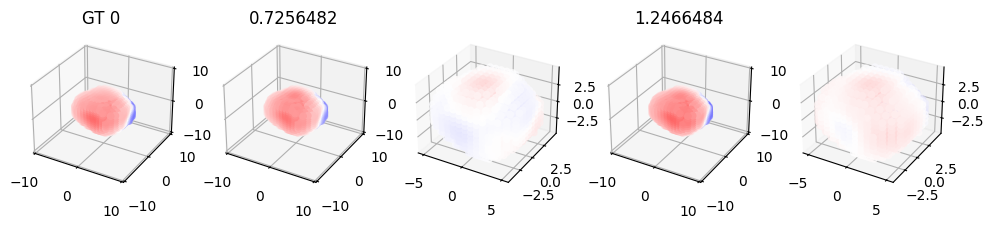

(Array(0.7256482, dtype=float32), Array(1.2466484, dtype=float32))

In [247]:
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [248]:
combined_pred_esp.shape

(3143,)

In [249]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

(11, 4)
4.0864725
Optimizing
(11,) 2442
Maximum number of function evaluations has been exceeded.
2516


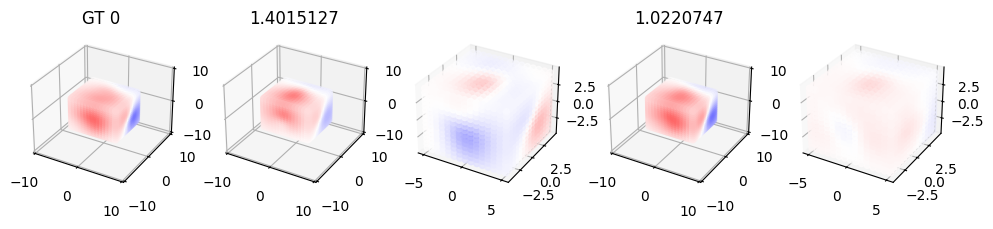

1538


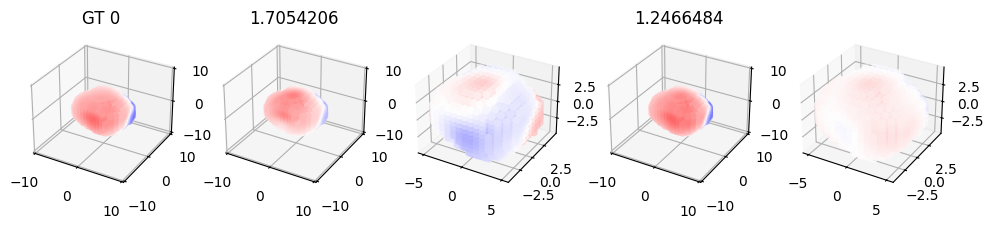

(Array(1.7054206, dtype=float32), Array(1.2466484, dtype=float32))

In [250]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array_mono,
                              atomwise_charge_array1
                              )
initial_rmse = get_esp_rmse_from_combined(combined, batch) 
print(initial_rmse)
opt_job = OptimizeCombined(combined, batch)
print("Optimizing")
res, combined_pred_esp, new_combined = opt_job.optimize()
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [251]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

In [252]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1.401499629020691
             x: [ 9.871e-02  9.957e-02 -9.962e-02 -1.000e-01 -7.219e-02
                 -1.552e-02  9.801e-02  5.709e-02  1.000e-01  9.989e-02
                  7.956e-03]
           nit: 1740
          nfev: 2442
 final_simplex: (array([[ 9.871e-02,  9.957e-02, ...,  9.989e-02,
                         7.956e-03],
                       [ 9.899e-02,  9.958e-02, ...,  9.983e-02,
                         8.109e-03],
                       ...,
                       [ 9.874e-02,  9.953e-02, ...,  9.990e-02,
                         8.134e-03],
                       [ 9.862e-02,  9.962e-02, ...,  9.995e-02,
                         7.321e-03]]), array([ 1.401e+00,  1.402e+00,  1.402e+00,  1.402e+00,
                        1.402e+00,  1.402e+00,  1.402e+00,  1.402e+00,
                        1.402e+00,  1.402e+00,  1.402e+00,  1.402e+00]))

In [253]:
from mulitmodel import combine_chg_arrays_indexed, OptimizeCombined

(14, 4)
2.7385228
Optimizing
(14,) 3192
Maximum number of function evaluations has been exceeded.
2516


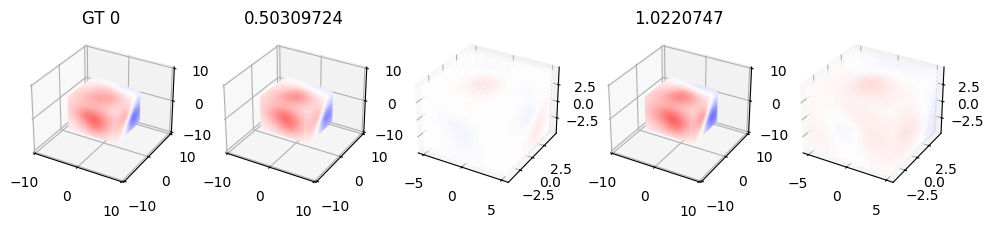

1538


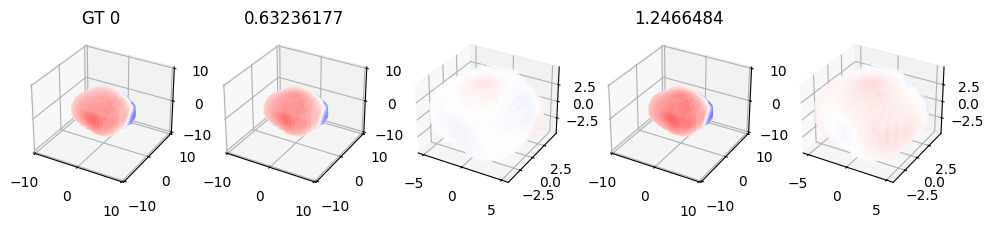

In [254]:
combined = combine_chg_arrays_indexed(batch,
                              atomwise_charge_array_mono,
                              atomwise_charge_array2,
                              indices=quads_ranked_cutoff
                              )

initial_rmse = get_esp_rmse_from_combined(combined, batch) 
print(initial_rmse)
opt_job = OptimizeCombined(combined, batch)
print("Optimizing")
res, combined_pred_esp, new_combined = opt_job.optimize()
l1, l1m = plot_esp(combined_pred_esp, batch, rcut=100.0)
l2, l2m = plot_esp(combined_pred_esp, batch, rcut=4.0)

In [255]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.5030924081802368
             x: [ 2.765e-02  8.576e-02 ... -1.197e-02 -3.176e-02]
           nit: 2265
          nfev: 3192
 final_simplex: (array([[ 2.765e-02,  8.576e-02, ..., -1.197e-02,
                        -3.176e-02],
                       [ 2.910e-02,  8.600e-02, ..., -1.229e-02,
                        -3.219e-02],
                       ...,
                       [ 3.168e-02,  8.734e-02, ..., -1.382e-02,
                        -3.338e-02],
                       [ 3.293e-02,  8.757e-02, ..., -1.390e-02,
                        -3.342e-02]]), array([ 5.031e-01,  5.031e-01, ...,  5.035e-01,  5.035e-01]))

In [256]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

(15, 4)
1.0501964
Optimizing
(15,) 3450
Maximum number of function evaluations has been exceeded.
2516


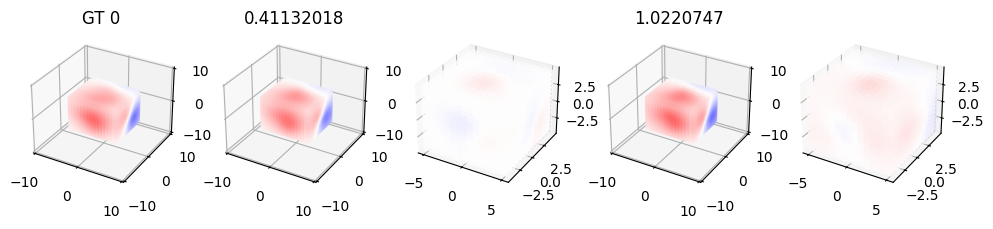

1538


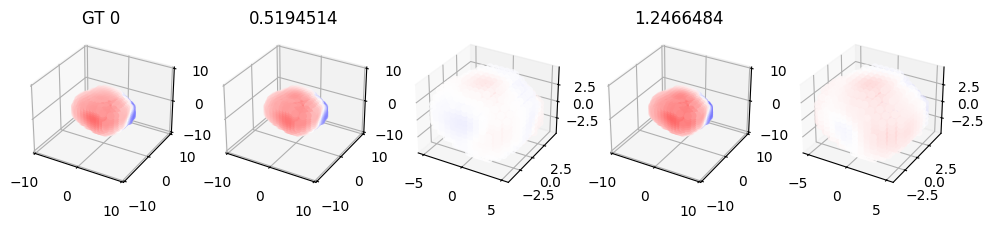

In [257]:
combined = combine_chg_arrays_indexed(batch,
                              atomwise_charge_array_mono,
                              atomwise_charge_array2,
                              indices=dipoles_ranked_cutoff
                              )

initial_rmse = get_esp_rmse_from_combined(combined, batch) 
print(initial_rmse)
opt_job = OptimizeCombined(combined, batch)
print("Optimizing")
res, combined_pred_esp, new_combined = opt_job.optimize()
l1, l1m = plot_esp(combined_pred_esp, batch, rcut=100.0)
l2, l2m = plot_esp(combined_pred_esp, batch, rcut=4.0)

In [258]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.4113161563873291
             x: [-1.287e-02 -3.059e-02 ...  2.752e-02  2.168e-02]
           nit: 2566
          nfev: 3450
 final_simplex: (array([[-1.287e-02, -3.059e-02, ...,  2.752e-02,
                         2.168e-02],
                       [-1.075e-02, -3.234e-02, ...,  2.759e-02,
                         2.148e-02],
                       ...,
                       [-1.185e-02, -3.264e-02, ...,  2.829e-02,
                         2.217e-02],
                       [-1.170e-02, -3.232e-02, ...,  2.797e-02,
                         2.200e-02]]), array([ 4.113e-01,  4.113e-01, ...,  4.114e-01,  4.114e-01]))

In [259]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

In [260]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array_mono,
                              atomwise_charge_array3
                              )
get_esp_rmse_from_combined(combined, batch)

(19, 4)


Array(2.0420878, dtype=float32)

In [261]:
combined.shape

(19, 4)

In [262]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(19,) 4522
Maximum number of function evaluations has been exceeded.


In [263]:
print(res.x)

[-0.02540452 -0.01181347  0.02518561  0.01816762 -0.01077611 -0.00129649
  0.00858861 -0.00523721 -0.05466704 -0.09943684 -0.07658599  0.09452694
 -0.02664555 -0.00101849 -0.02112548  0.03118769  0.01393664  0.08372499
  0.03600963]


2516


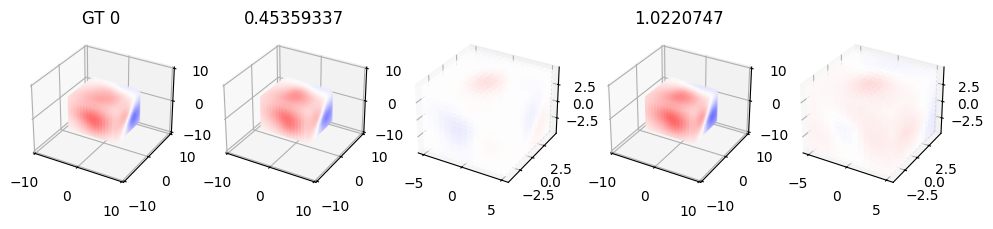

1538


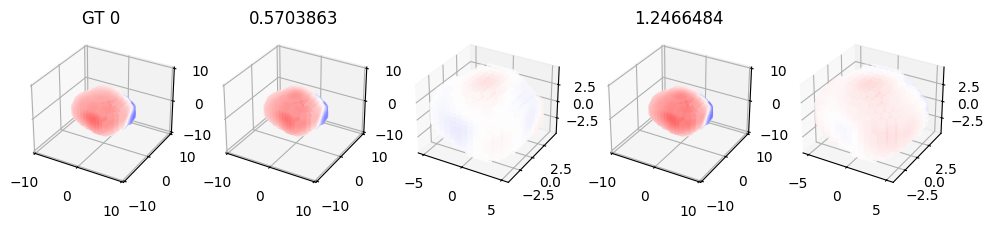

In [264]:
l1, l1m = plot_esp(combined_pred_esp, batch, rcut=100.0)
l2, l2m = plot_esp(combined_pred_esp, batch, rcut=4.0)

In [265]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3

In [266]:
combined = combine_chg_arrays(batch,
                              atomwise_charge_array_mono,
                              atomwise_charge_array4
                              )
get_esp_rmse_from_combined(combined, batch)

(23, 4)


Array(2.6330762, dtype=float32)

In [267]:
opt_job = OptimizeCombined(combined, batch)
res, combined_pred_esp, new_combined = opt_job.optimize()

(23,) 5658
Maximum number of function evaluations has been exceeded.


2516


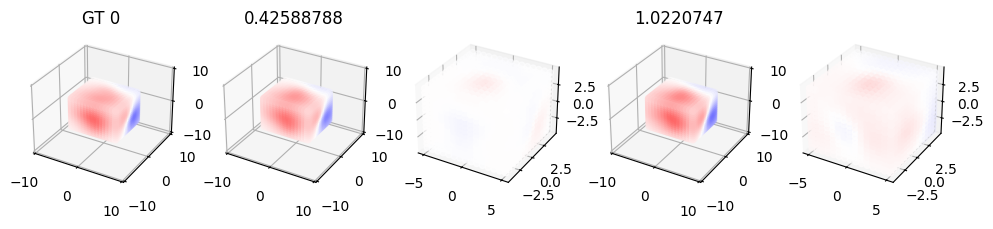

1538


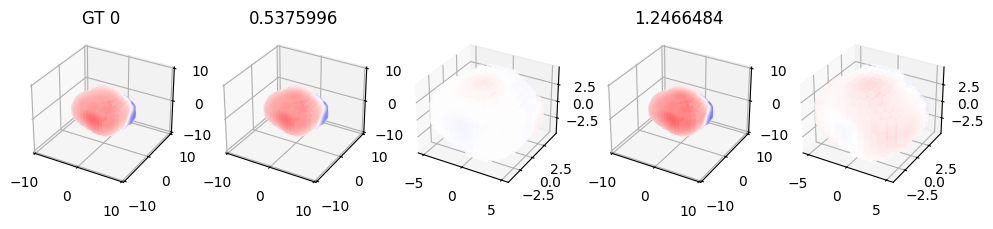

(Array(0.5375996, dtype=float32), Array(1.2466484, dtype=float32))

In [268]:
plot_esp(combined_pred_esp, batch, rcut=100.0)
plot_esp(combined_pred_esp, batch, rcut=4.0)

In [269]:
V1, V2, V3 = plot_3d_combined(new_combined, batch)
V3